## Recreating GAN networks from scratch based on the paper by I. Goodfellow

In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from yaml import load, Loader
import itertools

import matplotlib.pyplot as plt
import itertools
import math
from IPython import display

In [141]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")

Is CUDA supported by this system? True


Loading the data

In [155]:
# loading hyperparameters
file = open('config.yml', 'r')
config = load(file, Loader)

k = config['k']
lr = config['lr']
gen_step = config['gen_steps']
epochs = config['epochs']
image_size = config['input_size']
output_size = config['output_size']
hidden_layers_d = config['discriminator_layers']
hidden_layers_g = config['generator_layers']

In [143]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Creating a class to cover G

In [144]:
# This class needs to be able to train on
class Generator(nn.Module):
    def __init__(self, image_size, hidden_layers, output_size):
        super(Generator, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(output_size, hidden_layers[0]))

        for i, hidden_layer in enumerate(hidden_layers[:-1]):
            self.layers.append(nn.Linear(hidden_layer, hidden_layers[i+1]))

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_layers[-1], image_size)

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        return self.tanh(self.output(x))
        


Creating a class to cover D

In [145]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_layers, output_size, dropout_prob=0.1):
        super(Discriminator, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(image_size, hidden_layers[0]))
        
        for i, hidden_layer in enumerate(hidden_layers[:-1]):
            self.layers.append(nn.Linear(hidden_layer, hidden_layers[i+1]))

        self.dropout = nn.Dropout(p=dropout_prob)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(hidden_layers[-1], output_size)


    def forward(self, x):
        for layer in self.layers:
            x = self.dropout(self.relu(layer(x)))
        return self.sigmoid(self.output(x))

In [146]:
def generate_noise(n_samples):
    return torch.randn(n_samples, output_size).to(device)

In [148]:
discriminator = Discriminator(image_size, hidden_layers_d, 1).to(device)
generator = Generator(image_size, hidden_layers_g, output_size).to(device)

In [149]:
loss = nn.BCELoss()
optimizer_d = torch.optim.SGD(discriminator.parameters(), lr=lr)
optimizer_g = torch.optim.SGD(generator.parameters(), lr=lr)

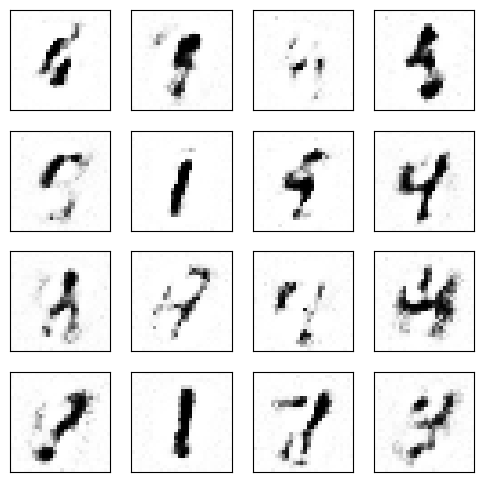

In [156]:
size_figure_grid = int(np.sqrt(16))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

epoch_losses_d, epoch_losses_g = [], []

noise = generate_noise(16)

for epoch in range(epochs):
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}')

    optimizer_d.zero_grad()
    optimizer_g.zero_grad()

    losses_d, losses_g = [], []
    for i, (images, _) in enumerate(train_loader):
        images = images.view(batch_size, -1).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        outputs = discriminator(images)
        d_loss_real = loss(outputs, real_labels)

        z = torch.randn(batch_size, output_size).to(device)
        fake_images = generator(z)
        ouputs = discriminator(fake_images)
        d_loss_fake = loss(ouputs, fake_labels)

        d_loss = d_loss_fake + d_loss_real
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()
        d_loss.backward()
        optimizer_d.step()
        losses_d.append(d_loss.item())

        z = torch.randn(batch_size, output_size).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)

        g_loss = loss(outputs, real_labels)

        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        g_loss.backward()
        optimizer_g.step()
        losses_g.append(g_loss.item())

        if (i + 1) % 100 == 0:

            test_images = generator(noise)
            for k in range(16):
                i = k // 4
                j = k % 4
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k, :].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)

    epoch_losses_d.append(np.mean(losses_d))
    epoch_losses_g.append(np.mean(losses_g))
    

